In [0]:
!pip install torch torchvision

In [0]:
%matplotlib inline
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import copy
import random


# Retinal Vessel Detection

Dataset used: *[DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/)*

Loading dataset on colab...

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd drive/"My Drive"/datasets

/content/drive/My Drive/datasets


In [0]:
cp DRIVE.zip ../../../

In [0]:
!unzip DRIVE.zip

In [12]:
ls

drive/  DRIVE/  DRIVE.zip  sample_data/


# Crop Images

Multiple pixel and the challenge is to label each and every pixel. Annotate each pixel known as sementic segmentation.
Take a 10x10 patch, and the center pixels label is associated with that patch.

In [0]:
# crop random 10 x 10 patches from images and also get the corresponding label

def img_transfer(img,imgLabel, bh, bw, no_of_patch):
    
    h = img.shape[0]
    w = img.shape[1]
    c = img.shape[2]
    ImgArr = np.empty((no_of_patch, bh*bw*3)) 
    LabelArr = np.empty((no_of_patch, bh*bw*1))
    
    # Get random patches
    for i in range(no_of_patch):
        ih = random.randint(0, h-bh)
        iw = random.randint(0, w-bw)
        iArrI = img[ih:ih+bh,iw:iw+bw,:]
        iArrL = imgLabel[ih:ih+bh,iw:iw+bw,:]       
        for ci in range(c):
            for bhi in range(bh):
                for bwi in range(bw):
                    # Add to image array
                    ImgArr[i][ci*bh*bw + bhi*bw + bwi] = iArrI[bhi][bwi][ci]
                    # first channel
                    if ci == 0:
                        LabelArr[i][ci*bh*bw + bhi*bw + bwi] = iArrL[bhi][bwi][ci]
        
    return ImgArr,LabelArr

In [0]:
def create_dset(patchH, patchW, PatchperImage, settype='train'):
  """
  patchH: Patch height
  patchW: Patch width
  PatchperImage: Number of patches per image
  settype: Can be either train or test
  """
  if settype == 'train':
    Datapath = 'DRIVE/training/images/'
    # 2 different annotations by different oplthalmologists
    Labelpath = 'DRIVE/training/1st_manual/'
  elif settype == 'test':
    Datapath = 'DRIVE/test/images/'
    # 2 different annotations by different oplthalmologists
    Labelpath = 'DRIVE/test/1st_manual/'
  else:
    raise ValueError("settype can be either 'test' or 'train'")
  
  images = torch.DoubleTensor(20*PatchperImage,3*patchH*patchW) # 20 such images
  labels = torch.DoubleTensor(20*PatchperImage,patchH*patchW) 
  t_no = 0
  for img_no in range(20):
      if settype == 'train':
        dp = Datapath + str(img_no+21) + '_training.tif'
        lp = Labelpath + str(img_no+21) + '_manual1.gif'
      elif settype == 'test':
        dp = Datapath + "%02d"%(img_no+1) + '_test.tif'
        lp = Labelpath + "%02d"%(img_no+1) + '_manual1.gif'
      imD = Image.open(dp)
      imD = np.array(imD)    

      imL = Image.open(lp)
      imL = np.array(imL)
      imL = np.reshape(imL, (imL.shape[0],imL.shape[1],1))

      imD,imL = img_transfer(imD,imL, patchH, patchW, PatchperImage)
      imD = imD/255.0
      imL = imL/255.0
      for i in range(PatchperImage):
          images[t_no] = torch.from_numpy(imD[i])
          labels[t_no] = torch.from_numpy(imL[i])
          t_no = t_no + 1
  return images, labels
    

# Model 2: Sparse Autoencoder

In [0]:
patchH = 10 # height of the patch
patchW = 10 # width of the patch
PatchperImage = 1000 # no of patches per image

In [0]:
TrainImages,TrainLabels = create_dset(patchH, patchW, PatchperImage, settype='train')

In [0]:
TestImages, TestLabels = create_dset(patchH, patchW, PatchperImage, settype='test')

In [16]:
print(TrainImages.size())
print(TrainLabels.size())

print(TestImages.size())
print(TestLabels.size())

torch.Size([20000, 300])
torch.Size([20000, 100])
torch.Size([20000, 300])
torch.Size([20000, 100])


In [0]:
batch_size = 32
n_iters = 50000
num_epochs = int(n_iters / (len(TrainImages)/batch_size))

train_dataset = torch.utils.data.TensorDataset(TrainImages, TrainLabels)
test_dataset = torch.utils.data.TensorDataset(TestImages, TestLabels)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



In [17]:
print(n_iters)
print(num_epochs)

50000
80


In [19]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


In [0]:
 class SparseAutoencoder(nn.Module):
    def __init__(self, l1weight):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(patchH*patchW*3, patchH*patchW),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(patchH*patchW, patchH*patchW*3),
            nn.Sigmoid())
        self.l1weight = l1weight

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded



In [61]:

net = SparseAutoencoder(0.1)
print(net)


SparseAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): Sigmoid()
  )
)
On GPU


In [0]:

if use_gpu:
    net = net.double().cuda()
    print('On GPU')
else:
    net = net.double()

In [0]:
# A tensor of 1 x 100. We would like the average activation of each hidden neuron j to be close to 0.1.
rho = torch.ones((32, 100)).double().cuda() * 0.1

In [0]:
mse = torch.nn.MSELoss()
kld = torch.nn.KLDivLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [86]:
trainLoss = []

iter = 0
for epoch in range(num_epochs):
  runningLoss = 0.0
  for images, labels in train_loader:
    
    if use_gpu:
      images = Variable(images.double()).cuda() # No need to resize
    else:
      images = Variable(images.double()) # No need to resize  
    
    optimizer.zero_grad()
    
    encoded, decoded = net(images)
    
    loss = mse(images, decoded) + (3 * kld(encoded, rho))
 
    loss.backward()
    
    optimizer.step()
    runningLoss += loss.data[0]
    
  trainLoss.append(runningLoss/(TrainImages.size()[0]/batch_size))
  if epoch % 10 == 0:
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,num_epochs,runningLoss/
                                                                (TrainImages.size()[0]/batch_size)))
print('Finished Training')
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


At Iteration : 1 / 80  ;  Mean-Squared Error : 204.076611
At Iteration : 11 / 80  ;  Mean-Squared Error : 8.513684
At Iteration : 21 / 80  ;  Mean-Squared Error : 6.241933
At Iteration : 31 / 80  ;  Mean-Squared Error : 5.077938
At Iteration : 41 / 80  ;  Mean-Squared Error : 4.521719
At Iteration : 51 / 80  ;  Mean-Squared Error : 4.074574
At Iteration : 61 / 80  ;  Mean-Squared Error : 3.588551
At Iteration : 71 / 80  ;  Mean-Squared Error : 3.042200
Finished Training


Text(0,0.5,'Training loss')

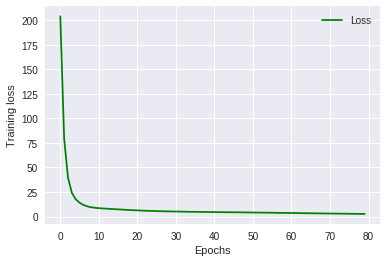

In [87]:
fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss')

## Sparse AE with penalty for classification

In [0]:
class L1Penalty(Function):

    @staticmethod
    def forward(ctx, input, l1weight):
        ctx.save_for_backward(input)
        ctx.l1weight = l1weight
        return input

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = input.clone().sign().mul(ctx.l1weight)
        grad_input += grad_output
        return grad_input, None

In [35]:
class autoencoder(nn.Module):
    def __init__(self, l1weight):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(patchH*patchW*3, patchH*patchW),
            nn.ReLU())
        self.classifier = nn.Sequential(nn.Linear(patchH*patchW,
                                               patchH*patchW),
                                     nn.Sigmoid())
        self.l1weight = l1weight

    def forward(self, x):
        x = self.encoder(x)
        x = L1Penalty.apply(x, self.l1weight)
        x = self.classifier(x)
        return x


net = autoencoder(0.8)
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Sigmoid()
  )
)


In [0]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [37]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    runningLoss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
        runningLoss += loss.data[0]
        
    testloss = 0.0
    for data in test_loader:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        testloss += loss.data[0]
    if epoch % 10 == 0:  
      print('At Iteration : %d / %d  ;  Train Error : %f ;Test Error : %f'%(epoch + 1,num_epochs,
                                                                        runningLoss/(20000/batch_size),testloss/(20000/batch_size)))
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


At Iteration : 1 / 80  ;  Train Error : 0.587768 ;Test Error : 0.502647
At Iteration : 11 / 80  ;  Train Error : 0.296188 ;Test Error : 0.306518
At Iteration : 21 / 80  ;  Train Error : 0.296187 ;Test Error : 0.306532
At Iteration : 31 / 80  ;  Train Error : 0.296185 ;Test Error : 0.306522
At Iteration : 41 / 80  ;  Train Error : 0.296186 ;Test Error : 0.306529
At Iteration : 51 / 80  ;  Train Error : 0.296187 ;Test Error : 0.306538
At Iteration : 61 / 80  ;  Train Error : 0.296184 ;Test Error : 0.306553
At Iteration : 71 / 80  ;  Train Error : 0.296185 ;Test Error : 0.306525
Finished Training


## Modifying the autoencoder for classification

In [93]:
class SparseAutoencoderClassifier(nn.Module):
    def __init__(self, l1weight):
        super(SparseAutoencoderClassifier, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(patchH*patchW*3, patchH*patchW),
            nn.ReLU())
        self.classifier = nn.Sequential(
            nn.Linear(patchH*patchW, 100),
            nn.Sigmoid())
        self.l1weight = l1weight

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.classifier(encoded)
        return encoded, decoded
net = SparseAutoencoderClassifier(0.1)
net.add_module('classifier', nn.Sequential(nn.Linear(patchH*patchW, patchH*patchW),nn.Sigmoid()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

SparseAutoencoderClassifier(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Sigmoid()
  )
)


In [0]:
bce = nn.BCELoss()
kld2 = nn.KLDivLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [103]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    runningLoss = 0.0
    for data in train_loader:
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        net.zero_grad()  # zeroes the gradient buffers of all parameters
        
        encoded, outputs = net(inputs)
    
        loss = bce(outputs, labels) + (3 * kld2(encoded, rho))
 
        loss.backward() #  backpropagate the loss
  
        optimizer.step()
        runningLoss += loss.data[0]
        
    testloss = 0.0
    for data in test_loader:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            
        encoded, outputs = net(inputs)
        loss = bce(outputs, labels) + (3 * kld2(encoded, rho))
        
        testloss += loss.data[0]
        
    if epoch % 10 == 0:  
      print('At Iteration : %d / %d  ;  Train Error : %f ;Test Error : %f'%(epoch + 1,num_epochs,
                                                                        runningLoss/(20000/batch_size),testloss/(20000/batch_size)))
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


At Iteration : 1 / 80  ;  Train Error : -8.167653 ;Test Error : -16.699881
At Iteration : 11 / 80  ;  Train Error : -149.911334 ;Test Error : -160.719047
At Iteration : 21 / 80  ;  Train Error : -324.352292 ;Test Error : -340.424566
At Iteration : 31 / 80  ;  Train Error : -505.210330 ;Test Error : -526.014297
At Iteration : 41 / 80  ;  Train Error : -677.870313 ;Test Error : -701.036645
At Iteration : 51 / 80  ;  Train Error : -847.577152 ;Test Error : -873.717196
At Iteration : 61 / 80  ;  Train Error : -1016.639052 ;Test Error : -1046.219302
At Iteration : 71 / 80  ;  Train Error : -1185.601317 ;Test Error : -1218.652680
Finished Training


In [0]:
# Can't understand why negative loss...

## Testing

In [0]:
imD = Image.open('DRIVE/test/images/01_test.tif')
imD = np.array(imD) 
imD = imD/255.0
    
imL = Image.open('DRIVE/test/1st_manual/01_manual1.gif')
imL = np.array(imL)
imL = imL/255.0

In [0]:
# Break the image into 10 x 10 patches and push the patches into the network for vessel detection

TestArr = np.zeros(patchH*patchW*3)
imout = np.zeros((imD.shape[0],imD.shape[1]))

for i in range(imD.shape[0]//patchH):
    for j in range(imD.shape[1]//patchW):
        for l1 in range(3):
            for l2 in range(patchH):
                for l3 in range(patchW):
                    TestArr[l1*patchH*patchW + l2*patchW + l3] = imD[i*patchH +l2][j*patchW+l3][l1]
        TestTensor = torch.from_numpy(TestArr)
        out = net(Variable(TestTensor.double().cuda()))
        outArr = out.data.cpu().numpy()
        for l2 in range(patchH):
            for l3 in range(patchW):
                imout[i*patchH +l2][j*patchW+l3] = outArr[l2*patchW + l3]

In [0]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size
plt.figure()
plt.subplot(1, 3, 1)
npimg = imD
npimg = np.abs(npimg)
plt.title('Input Image')
plt.imshow(npimg)

plt.subplot(1, 3, 2)
npimg = imout
npimg = np.abs(npimg)
plt.title('Classifier Output')
plt.imshow(npimg, 'gray')

plt.subplot(1, 3, 3)
npimg = imL
npimg = np.abs(npimg)
plt.title('Manual Label')
plt.imshow(npimg, 'gray')